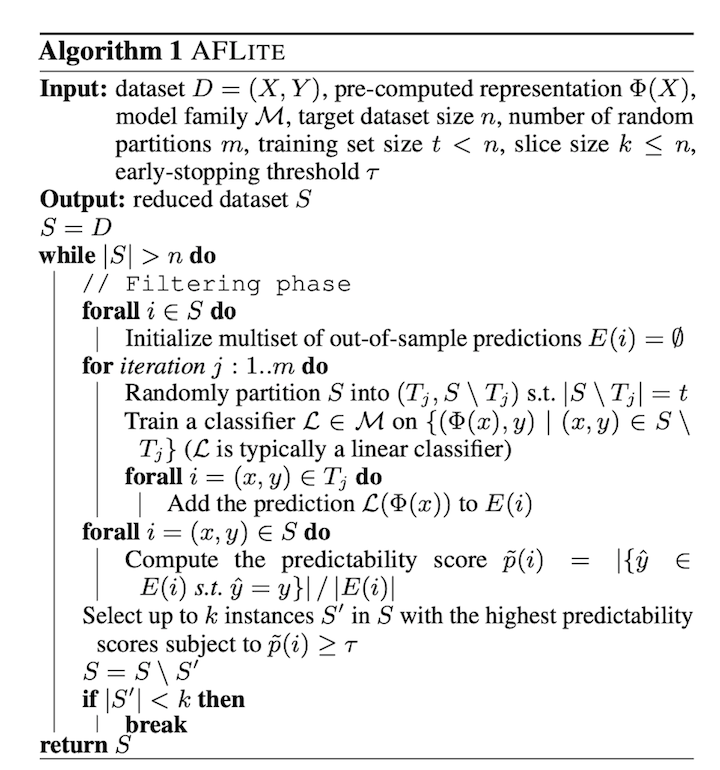






hpp from paper

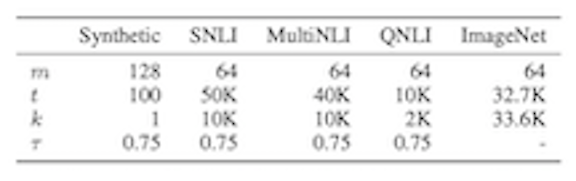

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

In [3]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cpu


In [4]:
## Features from BERT-Large, https://github.com/yg211/bert_nli
df = pd.read_json('/content/drive/MyDrive/ColabNotebooks/anli/anli_v1.0/R1/train.jsonl', lines=True)
label = pd.factorize(df['label'])[0]
feature_file = np.load('/content/drive/MyDrive/ColabNotebooks/Deliverables/features_R1.npz')
features = feature_file['arr_0']
print(len(label))
global_index = np.arange(len(label))
global_index_half = None
global_index_twothird = None
label = torch.from_numpy(label).to(device)
features = torch.from_numpy(features).to(device)

ValueError: ignored

In [ ]:
## model
class classifier(nn.Module):
    def __init__(self,input_size,num_classes = 3):
        super().__init__()
        self.model = nn.Linear(input_size, num_classes)
        self.softmax = nn.Softmax(dim = 1)
        
    def fit(self, epochs, lr, train_loader, opt_func=torch.optim.Adam, criterion = torch.nn.CrossEntropyLoss()):
        optimizer = opt_func(self.parameters(), lr)
        
        for epoch in range(epochs):
           
            for feature,label in training_dataloader:
                pred = self.model(feature)
                loss = criterion(pred, label)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            #print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))
           
    def predict(self, test_features):
        self.eval()
        with torch.no_grad():
            pred = self.model(test_features)
            pred = torch.argmax(self.softmax(pred), axis = 1)
        return pred


In [ ]:
def train_model(model, training_dataloader, test_features, batch_size, learning_rate):        
    model.fit(batch_size,learning_rate, training_dataloader)
    predict_label = model.predict(test_features)
    return predict_label


In [ ]:
# Algorithm Parameter
RESULT_SIZE = int(len(label)/3)  ## [n] while filtered data is greather than this number, keep iterating predict - remove steps
TRAIN_RATIO = 0.1   ## [t/data_size] train set ratio
N_ITER = 64   ## [m] total iteration number
STOP_RULE = int(len(label)/40)  ## [k] in the algo, when removed sample is less than this number, break
PREDICTABILITY_THRES = 0.75  ## [T] when predictablility score (correct_pred / total_pred) is higher than this threshold, remove

# Model Parameter
batch_size = 92
num_epochs = 3
learning_rate = 0.00001
half = int(len(label)/2)
twothird = 2*int(len(label)/3)
print(RESULT_SIZE, STOP_RULE)

33486 2511


In [ ]:
## filter
round = 0
acc_list = []
while label.shape[0] >= RESULT_SIZE:

  print('Round [{}]'.format(round+1))

  ## initializing E: [(total_predict, total_correct)] to track out-of-sample prediction
  data_len = label.shape[0]
  E = np.array([0 for i in range(data_len*2)]).reshape(data_len, 2)

  ## iteration to update E
  for _ in range(N_ITER):
    print("\rIteration [{}/{}]".format(_+1, N_ITER), end=" ")
    ## random split train / test
    train_index = np.random.choice(data_len, int(TRAIN_RATIO*data_len), replace=False)
    test_index = ~np.isin(range(data_len), train_index)
    train_data, test_data, train_label, test_label = features[train_index], features[test_index], label[train_index], label[test_index]

    in_f = train_data.float()
    in_l = train_label.long()
    training_set = TensorDataset(in_f, in_l)
    training_dataloader = DataLoader(training_set, batch_size, shuffle=True)

    out_f = test_data.float()
    out_l = test_label.long()
        
    ## predict
    model = classifier(features.shape[-1], num_classes = 3).to(device)
    predict_label = train_model(model, training_dataloader, out_f, batch_size, learning_rate)
    del model
    
    ## update E
    E[test_index, 0] += 1
    E[test_index, 1] += (predict_label == out_l).cpu().numpy()

  ## after N_iter, summarize predictability score, filter high p (p > PREDICTABILITY_THRES)
  accuracy = E[:,1]/E[:,0]
  print("Average accuracy: {}".format(np.mean(accuracy)), end=" ")
  high_p_index = accuracy > PREDICTABILITY_THRES
  if sum(high_p_index) > STOP_RULE:
    index = accuracy.argsort()[-STOP_RULE:]
    high_p_index[:] = False
    high_p_index[index] = True
  remove_num = sum(high_p_index)
  print(f"remove {remove_num} samples")
  acc_list.append((len(label),np.mean(accuracy)))
  label = label[~high_p_index]
  features = features[~high_p_index]
  global_index = global_index[~high_p_index]
  round +=1

  if len(global_index)<=twothird and global_index_twothird is None:
    global_index_twothird = global_index
    print("down to 2/3")

  if len(global_index)<=half and global_index_half is None:
    global_index_half = global_index
    print("down to 1/2")

  ## if remove number less than STOP_RULE, break loop
  if remove_num < STOP_RULE:
    break

Round [1]
Iteration [64/64] Average accuracy: 0.7561633998209398 remove 2511 samples
Round [2]
Iteration [64/64] Average accuracy: 0.7498265263464962 remove 2511 samples
Round [3]
Iteration [64/64] Average accuracy: 0.7432259943260182 remove 2511 samples
Round [4]
Iteration [64/64] Average accuracy: 0.7359009862422877 remove 2511 samples
Round [5]
Iteration [64/64] Average accuracy: 0.7285472424948611 remove 2511 samples
Round [6]
Iteration [64/64] Average accuracy: 0.7206970925866037 remove 2511 samples
Round [7]
Iteration [64/64] Average accuracy: 0.7122555300504823 remove 2511 samples
Round [8]
Iteration [64/64] Average accuracy: 0.703544813574943 remove 2511 samples
Round [9]
Iteration [64/64] Average accuracy: 0.6937966111434626 remove 2511 samples
Round [10]
Iteration [64/64] Average accuracy: 0.6838688691678025 remove 2511 samples
Round [11]
Iteration [64/64] Average accuracy: 0.6729814614113377 remove 2511 samples
Round [12]
Iteration [64/64] Average accuracy: 0.661302094502352

In [ ]:
# Record count after filtering
print(pd.DataFrame(acc_list))
print(len(global_index))
print(len(global_index_twothird))
print(len(global_index_half))

32662
65305
47728


In [ ]:
# Write to JSON
filtered = df.iloc[global_index,:]
with open('/content/drive/MyDrive/ColabNotebooks/AFLite_Filtered.jsonl', 'w') as f:
    f.write(filtered.to_json(orient='records', lines=True))
filtered_twothrid = df.iloc[global_index_twothird,:]
with open('/content/drive/MyDrive/ColabNotebooks/AFLite_Filtered_twothird.jsonl', 'w') as f:
    f.write(filtered_twothrid.to_json(orient='records', lines=True))
filtered_half = df.iloc[global_index_half,:]
with open('/content/drive/MyDrive/ColabNotebooks/AFLite_Filtered_half.jsonl', 'w') as f:
    f.write(filtered_half.to_json(orient='records', lines=True))